In [13]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity
from spec_exam import Gen_beam_fits, Gen_DB_and_beams
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [26]:
os.path.isfile('../beams/o142_1_39170.g102.A.fits')

True

In [29]:
def Gen_DB_and_beams(gid, loc, RA, DEC):
    if loc == 'south':
        g102_list = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
        g141_list = glob(hpath + '3dhst/s_flt_files/*flt.fits')
        ref = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
        seg = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
        cat = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat'

    if loc == 'north':
        g102_list = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
        g141_list = glob(hpath + '3dhst/n_flt_files/*flt.fits')    
        ref = hpath + '/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits'
        seg = hpath + '/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.seg.fits'
        cat = hpath + '/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.cat'      
        
    flt_g102 = []
    obj_g102 =[]
    for i in range(len(g102_list)):
        pres,pos=Source_present(g102_list[i],RA,DEC)
        if pres==True:
            obj_g102.append(pos)
            flt_g102.append(g102_list[i])

    flt_g141 = []
    obj_g141 =[]
    for i in range(len(g141_list)):
        pres,pos=Source_present(g141_list[i],RA,DEC)
        if pres==True:
            obj_g141.append(pos)
            flt_g141.append(g141_list[i])
            
    g102_orients = []
    for i in range(len(flt_g102)):
        dat = fits.open(flt_g102[i])
        g102_orients.append(int(dat[0].header['PA_V3']))

    g141_orients = []
    for i in range(len(flt_g141)):
        dat = fits.open(flt_g141[i])
        g141_orients.append(int(dat[0].header['PA_V3']))
      
    if (len(obj_g102) < 1) | (len(obj_g141) < 1):
        print('object not found')
    else:

        xpos_g102,ypos_g102 = np.array(obj_g102).T
        xpos_g141,ypos_g141 = np.array(obj_g141).T

        g102_DB = pd.DataFrame({'g102_file' : flt_g102, 'g102_orient' : g102_orients, 'g102_xpos' : xpos_g102, 'g102_ypos' : ypos_g102})

        g141_DB = pd.DataFrame({'g141_file' : flt_g141, 'g141_orient' : g141_orients, 'g141_xpos' : xpos_g141, 'g141_ypos' : ypos_g141})

        obj_DB = pd.concat([g102_DB,g141_DB], ignore_index=True, axis=1)

        obj_DB.columns = ['g102_file','g102_orient','g102_xpos','g102_ypos','g141_file','g141_orient','g141_xpos','g141_ypos']

        obj_DB.to_pickle('../dataframes/file_list/{0}.pkl'.format(gid))

        if gid < 10000:
            galid = '0' + '{0}'.format(gid)
        else:
            galid = gid

        pa = obj_DB.g102_orient[0]
        num = 1

        for i in obj_DB.index:
            if obj_DB.g102_orient[i] > 0:
                if pa  == obj_DB.g102_orient[i]:
                    if os.path.isfile('../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid)):
                        print('skip ../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid))                
                        num +=1
                    else:
        #                 Gen_beam_fits(ref,seg,obj_DB.g102_file[i],cat,gid,num)
                        print('run../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid))                
                        pa  = obj_DB.g102_orient[i]
                        num += 1

                else:
                    pa  = obj_DB.g102_orient[i]
                    num = 1
                    if os.path.isfile('../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid)):
                        print('skip ../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid))
                        num+=1
                    else:
        #                 Gen_beam_fits(ref,seg,obj_DB.g102_file[i],cat,gid,num)
                        print('run../beams/o{0}_{1}_{2}.g102.A.fits'.format(int(pa), num, galid))                
                        num+=1

        pa = obj_DB.g141_orient[0]
        num = 1

        for i in obj_DB.index:
            if obj_DB.g141_orient[i] > 0:
                if pa  == obj_DB.g141_orient[i]:
                    if os.path.isfile('../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid)):
                        print('skip ../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid))                
                        num +=1
                    else:
    #                     Gen_beam_fits(ref, seg, obj_DB.g141_file[i], cat, gid, num, grism='G141')
                        print('run../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid))                
                        pa  = obj_DB.g141_orient[i]
                        num += 1
                else:
                    pa  = obj_DB.g141_orient[i]
                    num = 1
                    if os.path.isfile('../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid)):
                        print('skip ../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid))                
                        num +=1
                    else:
    #                     Gen_beam_fits(ref, seg, obj_DB.g141_file[i], cat, gid, num, grism='G141')
                        print('run../beams/o{0}_{1}_{2}.g141.A.fits'.format(int(pa), num, galid))                
                        num+=1

In [31]:
Gen_DB_and_beams(21427, 'north',189.368121,62.247344)

skip ../beams/o344_1_21427.g102.A.fits
skip ../beams/o345_1_21427.g102.A.fits
skip ../beams/o344_1_21427.g102.A.fits
skip ../beams/o344_2_21427.g102.A.fits
skip ../beams/o344_1_21427.g141.A.fits
skip ../beams/o344_2_21427.g141.A.fits
skip ../beams/o344_3_21427.g141.A.fits
skip ../beams/o344_4_21427.g141.A.fits
skip ../beams/o344_5_21427.g141.A.fits
skip ../beams/o344_6_21427.g141.A.fits
skip ../beams/o344_7_21427.g141.A.fits
skip ../beams/o344_8_21427.g141.A.fits


In [2]:
gal_id = 41520 

In [3]:
filelist = glob(hpath + 'Clear_data/flt_files/*flt.fits')

In [4]:
n_flt = []
s_flt = []
i_flt = []

for i in range(len(filelist)):
    dat = fits.open(filelist[i])
    if dat[0].header['OBSTYPE'] == 'SPECTROSCOPIC' and dat[0].header['DEC_TARG'] < 0:
        s_flt.append(filelist[i])
        
    if dat[0].header['OBSTYPE'] == 'SPECTROSCOPIC' and dat[0].header['DEC_TARG'] > 0:
        n_flt.append(filelist[i])

    if dat[0].header['OBSTYPE'] == 'IMAGING':
        i_flt.append(filelist[i])

In [6]:
for i in s_flt:
    copyfile(i, hpath + 'Clear_data/s_flt_files/' + i.replace(hpath + 'Clear_data/flt_files/',''))

for i in n_flt:
    copyfile(i, hpath + 'Clear_data/n_flt_files/' + i.replace(hpath + 'Clear_data/flt_files/',''))

In [18]:
g104fs = glob('/Volumes/Vince_research/3DHST/goodss_flt_files/*flt*')

In [22]:
s104_flt = []
i104_flt = []

for i in range(len(g104fs)):
    dat = fits.open(g104fs[i])
    if dat[0].header['OBSTYPE'] == 'SPECTROSCOPIC' and dat[0].header['DEC_TARG'] < 0:
        s104_flt.append(g104fs[i])

    if dat[0].header['OBSTYPE'] == 'IMAGING':
        i104_flt.append(g104fs[i])

In [24]:
for i in s104_flt:
    copyfile(i, hpath+ '3dhst/s_flt_files/' + i.replace('/Volumes/Vince_research/3DHST/goodss_flt_files/',''))

In [23]:
len(s104_flt),len(i104_flt),len(g104fs),

(152, 152, 304)

In [58]:
def Gen_beam_fits(mosiac, seg_map, grism_data, catalog, gal_id, orient_id, grism = 'G102'):
    # initialize
    flt = griz_model.GrismFLT(grism_file = grism_data,
                          ref_file = mosiac, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=False,force_grism = grism)
    
    # catalog / semetation image
    ref_cat = Table.read( catalog ,format='ascii')
    seg_cat = flt.blot_catalog(ref_cat,sextractor=False)
    
    ## Reset
    flt.object_dispersers = collections.OrderedDict()

    flt.compute_full_model(ids=seg_cat['id'], mags=26)

    # check if galaxy is present
    if gal_id in flt.object_dispersers.keys():
    
        # reload(grizli.model)
        beam = flt.object_dispersers[gal_id][2]['A'] # can choose other orders if available
        beam.compute_model()
        
        # check if object in frame
        org = [beam.sly_parent.start,beam.slx_parent.start]
        nx = beam.slx_parent.stop - beam.slx_parent.start
        ny = beam.sly_parent.stop - beam.sly_parent.start
        
        if (org[1]<0) | (org[1]+nx > 1014 +2*200) | (org[0]<0) | (org[0]+ny > 1014 +2*200):
            print('object not found')
        
        else:
            ### BeamCutout object
            co = griz_model.BeamCutout(flt, beam, conf=flt.conf)

            ### Write the BeamCutout object to a normal FITS file
            orient = int(fits.open(grism_data)[0].header['PA_V3'])

            co.write_fits(root='../beams/o{0}_{1}'.format(orient,orient_id), clobber=True)
            fits.setval('../beams/o{0}_{1}_{2}.{3}.A.fits'.format(orient, orient_id, gal_id,grism), 'EXPTIME', ext=0,
                        value=fits.open('../beams/o{0}_{1}_{2}.{3}.A.fits'.format(orient, orient_id, gal_id,grism))[1].header['EXPTIME'])
        
    else:
        print('object not found')

In [54]:
test = glob('/Users/vestrada/3dhst/s_flt_files/*fits')

In [55]:
for i in test:
    dat = fits.open(i)
    scale = dat[1].data.shape
    if (scale[0] != 1014) | (scale[1] != 1014):
        print(scale)

In [59]:
Gen_beam_fits(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
              hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
              '/Users/vestrada/Clear_data/s_flt_files/icxt24a5q_flt.fits',
              hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',28319,1)

/Users/vestrada/Clear_data/s_flt_files/icxt24a5q_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Using default C-based coordinate transformation...
/Users/vestrada/Clear_data/s_flt_files/icxt24a5q_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
object not found


In [12]:
orients = []
for i in range(len(flt_files)):
    dat = fits.open(flt_files[i])
    orients.append(np.round(dat[0].header['PA_V3']).astype(int))

In [14]:
xpos,ypos = np.array(obj_pos).T

In [20]:
obj_DB = pd.DataFrame({'file' : flt_files, 'orient' : orients, 'xpos' : xpos, 'ypos' : ypos})

In [3]:
obj_DB= pd.read_pickle('../dataframes/file_list/{0}.pkl'.format(gal_id))

In [4]:
num = 1
pa = obj_DB.orient[0]

for i in obj_DB.index:
    if pa  == obj_DB.orient[i]:
        
        Gen_beam_fits(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
         hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
         obj_DB.file[i],
         hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',gal_id,num)
        
        pa  = obj_DB.orient[i]
        num += 1
    
    else:
        pa  = obj_DB.orient[i]
        num = 1
        
        Gen_beam_fits(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
         hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
         obj_DB.file[i],
         hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',gal_id,num)
        
        num+=1



/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
Using default C-based coordinate transformation...
/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits / blot segmentation /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
/Users/Vince.ec/Clear_data/flt_files/icxt3

In [5]:
obj_DB.file

0     /Users/Vince.ec/Clear_data/flt_files/icxt30s0q...
1     /Users/Vince.ec/Clear_data/flt_files/icxt30s2q...
2     /Users/Vince.ec/Clear_data/flt_files/icxt30s5q...
3     /Users/Vince.ec/Clear_data/flt_files/icxt30s7q...
4     /Users/Vince.ec/Clear_data/flt_files/icxt31r1q...
5     /Users/Vince.ec/Clear_data/flt_files/icxt31r3q...
6     /Users/Vince.ec/Clear_data/flt_files/icxt31r6q...
7     /Users/Vince.ec/Clear_data/flt_files/icxt31r8q...
8     /Users/Vince.ec/Clear_data/flt_files/icxt32nlq...
9     /Users/Vince.ec/Clear_data/flt_files/icxt32nmq...
10    /Users/Vince.ec/Clear_data/flt_files/icxt32npq...
11    /Users/Vince.ec/Clear_data/flt_files/icxt32nrq...
12    /Users/Vince.ec/Clear_data/flt_files/icxt33roq...
13    /Users/Vince.ec/Clear_data/flt_files/icxt33rpq...
14    /Users/Vince.ec/Clear_data/flt_files/icxt33rsq...
15    /Users/Vince.ec/Clear_data/flt_files/icxt33ruq...
16    /Users/Vince.ec/Clear_data/flt_files/icxt34ekq...
17    /Users/Vince.ec/Clear_data/flt_files/icxt3

# Get list of all objects in CLEAR

In [6]:
if hpath == '/Users/Vince.ec/':
    goods_s=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
    goods_n=Table.read('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

    restc_s=Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
    restc_n=Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

    fast_s=Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
    fast_n=Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()
    
    eazy_s = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
                   format = 'ascii').to_pandas()
    eazy_n = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
                   format = 'ascii').to_pandas()
    
else:
    goods_s=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',format='ascii').to_pandas()
    goods_n=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',format='ascii').to_pandas()

    restc_s=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
    restc_n=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()
    
    fast_s=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
    fast_n=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

    eazy_s = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
                       format = 'ascii').to_pandas()
    eazy_n = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
                       format = 'ascii').to_pandas()

In [9]:
IDS=[]
IDN=[]

for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if 1.4 <= rshift <= 1.8 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 10:
        IDS.append(i)

for i in range(len(restc_n['id'])):
    if eazy_n.z_spec[i] != -1:
        rshift = eazy_n.z_spec[i]
    else: 
        rshift = eazy_n.z_peak[i]

    if 1.4 <= rshift <= 1.8 and goods_n['class_star'][i]<0.8 and fast_n['lmass'][i] >= 10:
        IDN.append(i)

In [14]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)

IDSQ=[]
IDSsf=[]

IDNQ=[]
IDNsf=[]

for i in range(len(uvS)):
    if uvS[i]>=0.88*vjS[i]+0.59 and uvS[i]>1.382 and vjS[i]<1.65:
        IDSQ.append(i)
    if uvS[i]<0.88*vjS[i]+0.59:
        IDSsf.append(i)
        
for i in range(len(uvN)):
    if uvN[i]>=0.88*vjN[i]+0.59 and uvN[i]>1.382 and vjN[i]<1.65:
        IDNQ.append(i)
    if uvN[i]<0.88*vjN[i]+0.59:
        IDNsf.append(i)

No handles with labels found to put in legend.


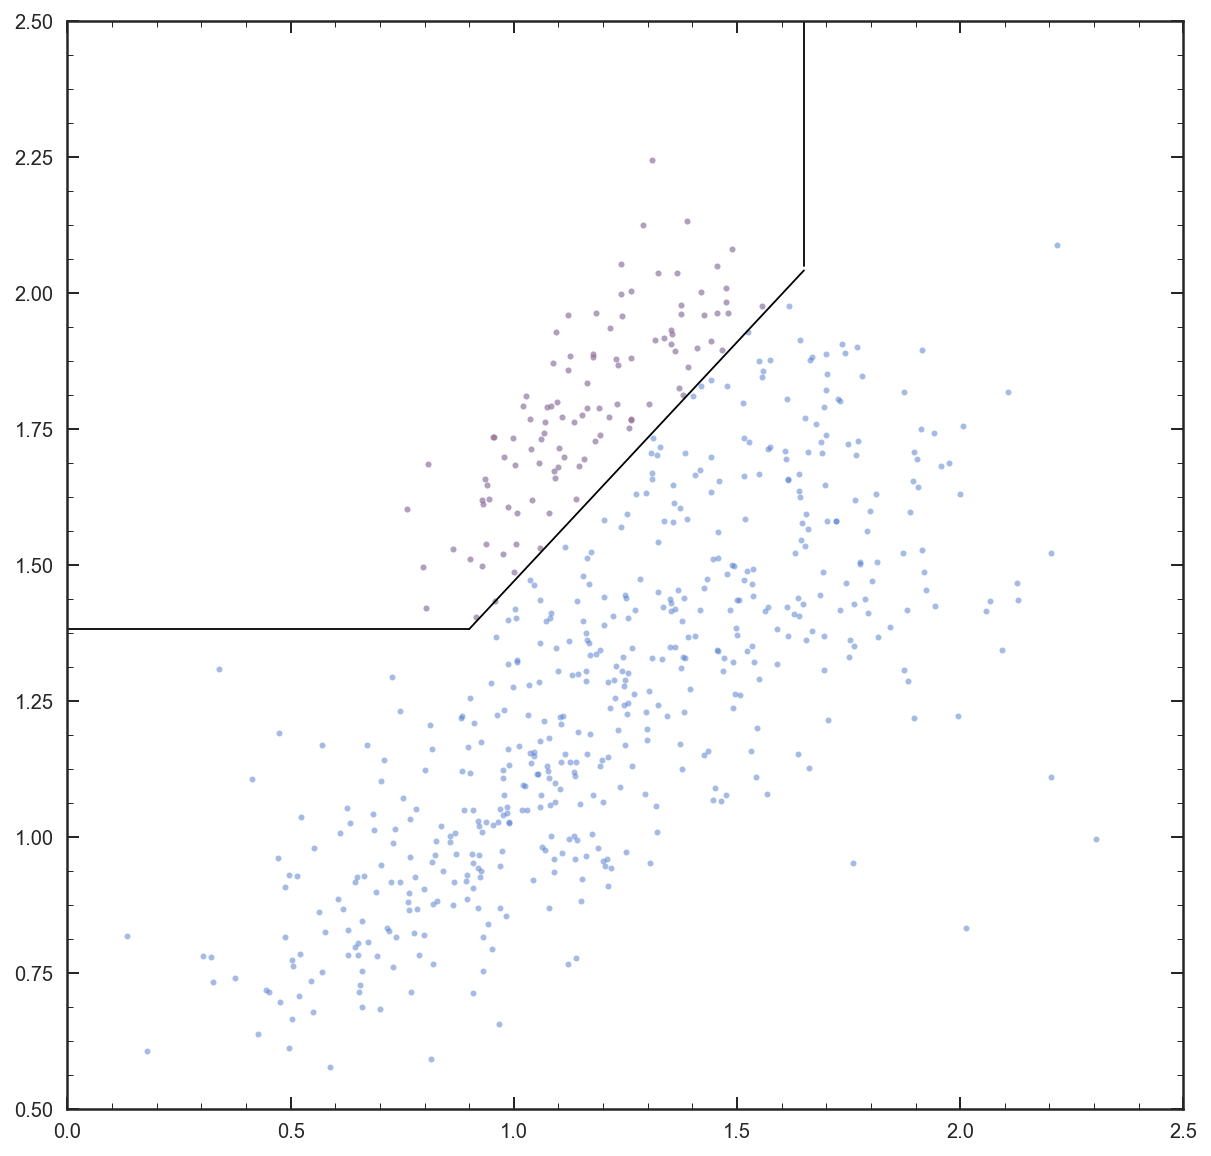

In [18]:
plt.figure(figsize=[10,10])
plt.plot(vjS,uvS,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjN,uvN,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjS[IDSQ],uvS[IDSQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot(vjN[IDNQ],uvN[IDNQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()

In [19]:
len(IDSQ), len(IDNQ)

(71, 34)

In [57]:
s_cand =pd.DataFrame({ 'gids' : eazy_s.id[np.array(IDS)[np.array(IDSQ)]],
    'zspec' : eazy_s.z_spec[np.array(IDS)[np.array(IDSQ)]],
    'zphot' : eazy_s.z_peak[np.array(IDS)[np.array(IDSQ)]],
    'ra' : goods_s.ra[np.array(IDS)[np.array(IDSQ)]],
    'dec' : goods_s.dec[np.array(IDS)[np.array(IDSQ)]],
    'in_out' : np.repeat('out',len(IDSQ))})

n_cand =pd.DataFrame({ 'gids' : eazy_n.id[np.array(IDN)[np.array(IDNQ)]],
    'zspec' : eazy_n.z_spec[np.array(IDN)[np.array(IDNQ)]],
    'zphot' : eazy_n.z_peak[np.array(IDN)[np.array(IDNQ)]],
    'ra' : goods_n.ra[np.array(IDN)[np.array(IDNQ)]],
    'dec' : goods_n.dec[np.array(IDN)[np.array(IDNQ)]],
    'in_out' : np.repeat('out',len(IDNQ))})

In [58]:
for i in s_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand.ra[i],s_cand.dec[i])
        if pres == True:
            s_cand.in_out[i]= 'in'
            break
            
for i in n_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand.ra[i],n_cand.dec[i])
        if pres == True:
            n_cand.in_out[i]= 'in'
            break

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [62]:
s_cand = s_cand.query('in_out == "in"')

In [63]:
n_cand = n_cand.query('in_out == "in"')

In [64]:
s_cand.to_pickle('../dataframes/galaxy_frames/s_candidates.pkl')
n_cand.to_pickle('../dataframes/galaxy_frames/n_candidates.pkl')

# Make list of UDS candidates

In [2]:
goods_u=Table.read(hpath + 'uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat',format='ascii').to_pandas()

restc_u=Table.read(hpath + 'uds_3dhst.v4.2.cats/RF_colors/uds_3dhst.v4.2.master.RF',format='ascii').to_pandas()

fast_u=Table.read(hpath + 'uds_3dhst.v4.2.cats/Fast/uds_3dhst.v4.2.fout',format='ascii').to_pandas()

eazy_u=Table.read(hpath + 'uds_3dhst.v4.2.cats/Eazy/uds_3dhst.v4.2.zout',format = 'ascii').to_pandas()

In [4]:
eazy_u.query('id == 29983')

,id,z_spec,z_a,z_m1,chi_a,z_p,chi_p,z_m2,odds,l68,u68,l95,u95,l99,u99,nfilt,q_z,z_peak,peak_prob,z_mc
29982,29983,-1.0,1.284,1.282,578.2766,1.284,578.2766,1.281,1.0,1.251,1.313,1.23,1.336,1.209,1.363,15,7.42487,1.2804,0.996,1.2769


In [5]:
IDU=[]

for i in range(len(restc_u['id'])):
    if eazy_u.z_spec[i] != -1:
        rshift = eazy_u.z_spec[i]
    else: 
        rshift = eazy_u.z_peak[i]

    if 1.4 <= rshift <= 1.8 and goods_u['class_star'][i]<0.8 and fast_u['lmass'][i] >= 10:
        IDU.append(i)
        
IDU.append(29982)

In [6]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvU=Mag(restc_u['L153'][IDU].values) - Mag(restc_u['L155'][IDU].values)
vjU=Mag(restc_u['L155'][IDU].values) - Mag(restc_u['L161'][IDU].values)

IDUQ=[]
IDUsf=[]


for i in range(len(uvU)):
    if uvU[i]>=0.88*vjU[i]+0.59 and uvU[i]>1.382 and vjU[i]<1.65:
        IDUQ.append(i)
    if uvU[i]<0.88*vjU[i]+0.59:
        IDUsf.append(i)

No handles with labels found to put in legend.


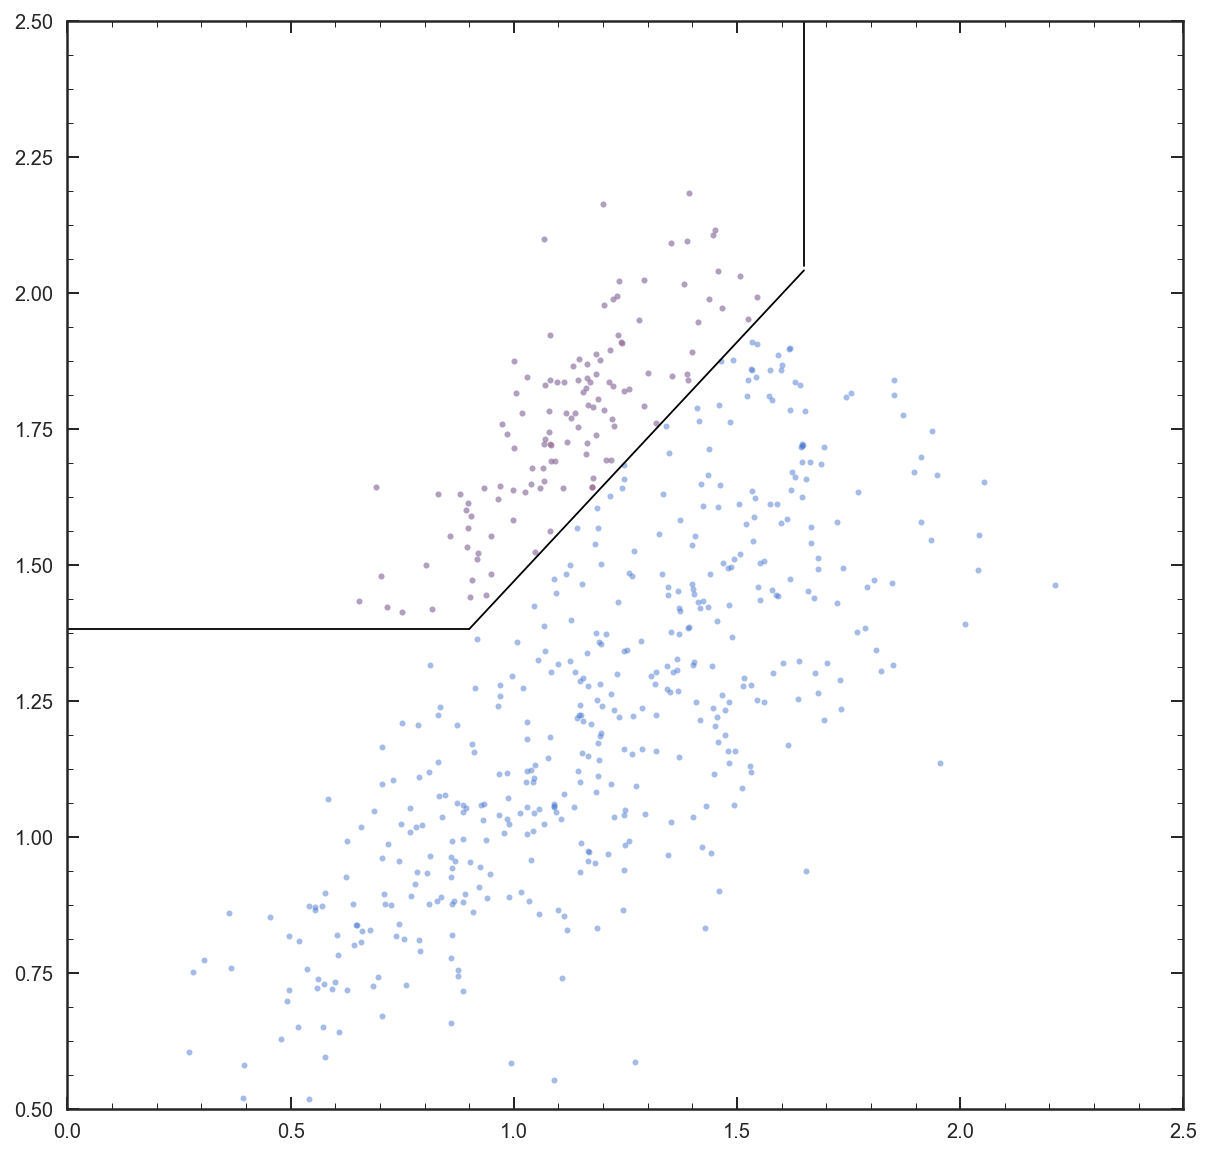

In [7]:
plt.figure(figsize=[10,10])
plt.plot(vjU,uvU,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjU[IDUQ],uvU[IDUQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()

In [8]:
u_cand =pd.DataFrame({ 'gids' : eazy_u.id[np.array(IDU)[np.array(IDUQ)]],
    'zspec' : eazy_u.z_spec[np.array(IDU)[np.array(IDUQ)]],
    'zphot' : eazy_u.z_peak[np.array(IDU)[np.array(IDUQ)]],
    'ra' : goods_u.ra[np.array(IDU)[np.array(IDUQ)]],
    'dec' : goods_u.dec[np.array(IDU)[np.array(IDUQ)]],
    'in_out' : np.repeat('out',len(IDUQ))})

In [9]:
filelist = glob('/Users/Vince.ec/uds_g102/*flt.fits')

In [10]:
for i in u_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],u_cand.ra[i],u_cand.dec[i])
        if pres == True:
            u_cand.in_out[i]= 'in'
            break

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
u_cand.query('in_out == "in"')

,dec,gids,in_out,ra,zphot,zspec
27955,-5.182406,27956,in,34.591887,1.7534,-1.0
28014,-5.182348,28015,in,34.591712,1.7036,-1.0
28706,-5.179726,28707,in,34.591723,1.6393,-1.0
29583,-5.177424,29584,in,34.580369,1.7678,-1.0
29898,-5.175789,29899,in,34.596961,1.5728,-1.0
30736,-5.175837,30737,in,34.587878,1.7260,-1.0
31683,-5.172182,31684,in,34.589770,1.6316,-1.0
32706,-5.167801,32707,in,34.573366,1.6995,-1.0
33091,-5.166139,33092,in,34.582782,1.6639,-1.0
33526,-5.164616,33527,in,34.571234,1.7199,-1.0


In [12]:
# u_cand.to_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [15]:
s_cand = pd.read_pickle('../dataframes/galaxy_frames/s_candidates.pkl')
n_cand = pd.read_pickle('../dataframes/galaxy_frames/n_candidates.pkl')

In [15]:
g141_s_list = glob(hpath + '3dhst/s_flt_files/*flt.fits')
g141_n_list = glob(hpath + '3dhst/n_flt_files/*flt.fits')    

In [16]:
for i in s_cand.index:
    for ii in range(len(g141_s_list)):
        pres,pos=Source_present(g141_s_list[ii],s_cand.ra[i],s_cand.dec[i])
        if pres == True:
            print(s_cand.gids[i])
            print(pos)
            
for i in n_cand.index:
    for ii in range(len(g141_n_list)):
        pres,pos=Source_present(g141_n_list[ii],n_cand.ra[i],n_cand.dec[i])
        if pres == True:
            print(n_cand.gids[i])
            print(pos)

26272
[623.36280911 -94.86449742]
26272
[633.38137316 -91.47807657]
26272
[630.00225294 -84.9371703 ]
26272
[619.87188106 -88.34735649]
26272
[574.77815789 844.18844575]
26272
[584.80034129 847.58734538]
26272
[581.26435099 854.08749923]
26272
[571.27571899 850.67731505]
26272
[206.2939362  494.12610321]
26272
[216.32230456 497.66503896]
26272
[212.80746571 504.11881434]
26272
[202.80196013 500.72551935]
26272
[134.97372577 453.33857938]
26272
[145.00387702 456.84197766]
26272
[141.51973276 463.33517449]
26272
[131.54390708 459.89561194]
26272
[256.93473342 480.47248847]
26272
[266.94886764 483.93295657]
26272
[263.43909339 490.44722388]
26272
[253.45843093 486.98787325]
26272
[201.89675794 421.26998218]
26272
[211.92182726 424.75766049]
26272
[208.33645139 431.23869927]
26272
[198.38790058 427.83986542]
28319
[156.33940506 -50.28563515]
28319
[166.40162595 -46.75530722]
28319
[162.85075941 -40.18727667]
28319
[152.9949546  -43.79517844]
28319
[120.29175922 970.54327056]
28319
[130.424

KeyboardInterrupt: 

In [3]:
s_cand

,dec,gids,in_out,ra,zphot,zspec
26271,-27.790601,26272,in,53.150826,1.5716,-1.0
28318,-27.782060,28319,in,53.173671,1.7817,-1.0
29256,-27.777637,29257,in,53.147471,1.6824,-1.0
36175,-27.742284,36176,in,53.121006,1.7098,-1.0
38842,-27.729749,38843,in,53.107039,1.6766,-1.0
39011,-27.727621,39012,in,53.064240,1.6573,-1.0
39363,-27.726461,39364,in,53.062821,1.6970,-1.0
40222,-27.722957,40223,in,53.124956,1.6508,-1.0
40622,-27.721152,40623,in,53.130480,1.4913,-1.0
41147,-27.718885,41148,in,53.127925,1.6965,-1.0


In [19]:
20 * 120 * 4

9600

In [2]:
goods_s=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

s_cand = pd.read_pickle('../dataframes/galaxy_frames/s_candidates.pkl')
n_cand = pd.read_pickle('../dataframes/galaxy_frames/n_candidates.pkl')

In [3]:
gs_keys = np.array(goods_s.keys())
gn_keys = np.array(goods_n.keys())

In [4]:
sflux_keys = []
serror_keys = []

for i in gs_keys:
    if i[0:2] == 'f_':
        sflux_keys.append(i)
    if i[0:2] == 'e_':
        serror_keys.append(i)
        
nflux_keys = []
nerror_keys = []

for i in gn_keys:
    if i[0:2] == 'f_':
        nflux_keys.append(i)
    if i[0:2] == 'e_':
        nerror_keys.append(i)

In [5]:
s_trans,sez_code=np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.translate',dtype=str).T
n_trans,nez_code=np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.translate',dtype=str).T

In [8]:
s_codes = []
s_keys = []
s_ekeys = []
n_codes = []
n_keys = []
n_ekeys = []

for i in range(len(sflux_keys)):
    if sez_code[np.argwhere(s_trans == sflux_keys[i])].size >0:
        s_codes.append(int(sez_code[np.argwhere(s_trans == sflux_keys[i])][0][0][1:]))
        s_keys.append(sflux_keys[i])
        s_ekeys.append(serror_keys[i])
        
for i in range(len(nflux_keys)):
    if nez_code[np.argwhere(n_trans == nflux_keys[i])].size >0:
        n_codes.append(int(nez_code[np.argwhere(n_trans == nflux_keys[i])][0][0][1:]))
        n_keys.append(nflux_keys[i])
        n_ekeys.append(nerror_keys[i])

In [43]:
for i in s_cand.index:
    filt = []
    ez_key = []
    eff_wvs = []
    phot = []
    phot_err = []
    for ii in range(len(s_codes)):
        if goods_s[s_keys[ii]][i] > 0:
            sw,sf,effwv=Get_Sensitivity(s_codes[ii])
            Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
            filt.append(s_keys[ii][2:])
            ez_key.append(s_codes[ii])
            eff_wvs.append(effwv)
            phot.append(Clam * goods_s[s_keys[ii]][i])
            phot_err.append(Clam * goods_s[s_ekeys[ii]][i])
     
    sw,sf,effwv=Get_Sensitivity(201)
    Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
    filt.append('F098M')
    ez_key.append(201)
    eff_wvs.append(effwv)
    phot.append(Clam * goods_s['f_F098M'][i])
    phot_err.append(Clam * goods_s['e_F098M'][i])
    
    phot_db = pd.DataFrame({'filter' : filt, 'EAZY_key' : ez_key, 'eff_wv' : eff_wvs,
                           'phot' : phot, 'phot_err' : phot_err})
    phot_db.to_pickle('../dataframes/phot/gs_{0}_phot.pkl'.format(s_cand.gids[i]))
    
    
for i in n_cand.index:
    filt = []
    ez_key = []
    eff_wvs = []
    phot = []
    phot_err = []
    for ii in range(len(n_codes)):
        if goods_n[n_keys[ii]][i] > 0:
            sw,sf,effwv=Get_Sensitivity(n_codes[ii])
            Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
            filt.append(n_keys[ii][2:])
            ez_key.append(n_codes[ii])
            eff_wvs.append(effwv)
            phot.append(Clam * goods_n[n_keys[ii]][i])
            phot_err.append(Clam * goods_n[n_ekeys[ii]][i])
            
    phot_db = pd.DataFrame({'filter' : filt, 'EAZY_key' : ez_key, 'eff_wv' : eff_wvs,
                           'phot' : phot, 'phot_err' : phot_err})
    phot_db.to_pickle('../dataframes/phot/gn_{0}_phot.pkl'.format(n_cand.gids[i]))

In [16]:
n_cand

,dec,gids,in_out,ra,zphot,zspec
6283,62.172293,6284,in,189.199728,1.7560,-1.0000
8465,62.184931,8466,in,189.156533,1.7063,-1.0000
11813,62.200346,11814,in,189.217095,1.6698,-1.0000
13116,62.206599,13117,in,189.260877,1.6337,-1.0000
21426,62.247344,21427,in,189.368121,1.4759,-1.0000
23025,62.254732,23026,in,189.032759,1.4788,-1.0000
23253,62.255761,23254,in,189.349606,1.4561,-1.0000
32690,62.307165,32691,in,189.347593,1.4266,-1.0000
33092,62.310363,33093,in,189.331982,1.4674,1.5198
37106,62.347600,37107,in,189.344334,1.6778,-1.0000


In [17]:
s_cand

,dec,gids,in_out,ra,zphot,zspec
26271,-27.790601,26272,in,53.150826,1.5716,-1.0
28318,-27.782060,28319,in,53.173671,1.7817,-1.0
29256,-27.777637,29257,in,53.147471,1.6824,-1.0
36175,-27.742284,36176,in,53.121006,1.7098,-1.0
38842,-27.729749,38843,in,53.107039,1.6766,-1.0
39011,-27.727621,39012,in,53.064240,1.6573,-1.0
39363,-27.726461,39364,in,53.062821,1.6970,-1.0
40222,-27.722957,40223,in,53.124956,1.6508,-1.0
40622,-27.721152,40623,in,53.130480,1.4913,-1.0
41147,-27.718885,41148,in,53.127925,1.6965,-1.0


In [38]:
for i in n_cand.index:
    p_file = glob('../dataframes/phot/*{0}*'.format(n_cand.gids[i]))[0]
    dat = pd.read_pickle(p_file)
    print(dat.query('filter == "F850LP"')['phot'].values)

[3.84408095e-20]
[4.23481863e-19]
[6.89412686e-20]
[1.90429397e-19]
[3.7373196e-19]
[5.30562923e-19]
[1.49544545e-19]
[2.48897002e-19]
[1.30274799e-19]
[3.14590391e-19]
[4.22947048e-19]
[3.96661115e-19]
[9.73296248e-20]
[8.12215803e-20]
[4.48057545e-20]
[3.64634188e-20]


In [30]:
glob('../dataframes/phot/*{0}*'.format(s_cand.gids[s_cand.index[0]]))[0]

'../dataframes/phot/gs_26272_phot.pkl'

In [37]:
np.array([n_keys,n_codes]).T

array([['f_F160W', '205'],
       ['f_U', '227'],
       ['f_F435W', '233'],
       ['f_B', '114'],
       ['f_G', '229'],
       ['f_V', '115'],
       ['f_F606W', '236'],
       ['f_R', '116'],
       ['f_Rs', '231'],
       ['f_I', '117'],
       ['f_F775W', '238'],
       ['f_Z', '118'],
       ['f_F850LP', '240'],
       ['f_F125W', '203'],
       ['f_J', '224'],
       ['f_F140W', '204'],
       ['f_H', '225'],
       ['f_Ks', '226'],
       ['f_IRAC1', '18'],
       ['f_IRAC2', '19'],
       ['f_IRAC3', '20'],
       ['f_IRAC4', '21']], dtype='<U8')

In [41]:
sflux_keys

['f_F160W',
 'f_U50',
 'f_U38',
 'f_U',
 'f_F435W',
 'f_B',
 'f_V',
 'f_F606Wcand',
 'f_F606W',
 'f_R',
 'f_Rc',
 'f_F775W',
 'f_I',
 'f_F814Wcand',
 'f_F850LP',
 'f_F850LPcand',
 'f_F098M',
 'f_F105W',
 'f_F125W',
 'f_J',
 'f_tenisJ',
 'f_F140W',
 'f_H',
 'f_tenisK',
 'f_Ks',
 'f_IRAC1',
 'f_IRAC2',
 'f_IRAC3',
 'f_IRAC4',
 'f_IA427',
 'f_IA445',
 'f_IA464',
 'f_IA484',
 'f_IA505',
 'f_IA527',
 'f_IA550',
 'f_IA574',
 'f_IA598',
 'f_IA624',
 'f_IA651',
 'f_IA679',
 'f_IA709',
 'f_IA738',
 'f_IA767',
 'f_IA797',
 'f_IA827',
 'f_IA856']